#DESAFÍO Nro. 3 NLP: custom embeddings con Gensim.

Las modificaciones realizadas en relación con el ejercicio original fueron:

* Utilizar como corpus el primer libro de Harry Potter.
* Utilizar, además de Skip-Gram, CBOW de ventana 2 y 4.
* Encontrar las relaciones entre términos en cada caso tiendo en cuenta el contexto del libro.
* Comparar los 3 casos y sacar conclusiones.

By Anahi Bazet

# Objetivo


El objetivo es utilizar un corpus para crear embeddings de palabras basado en ese contexto. 

Se elige el libro "Harry Potter y La piedra filosofal", primero de la saga, de la autora J.K. Rowling para generar los embeddings, es decir, que los vectores tendrán la forma en función de como la autora haya utilizado las palabras en el libro.

## 1 - Librerías

In [ ]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [ ]:
import gdown
import os
import pandas as pd
from keras.preprocessing.text import text_to_word_sequence
# import matplotlib.pyplot as plt
# import seaborn as sns
# import multiprocessing
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
import numpy as np

## 2 - Obtención de datos
Se utiliza como dataset los libros de Harry Potter de la autora J.K. Rowling.

In [ ]:
#Descargar el archivo del GD y descomprimirlo.
if os.access('HarryPotter.zip', os.F_OK) is False:
  url = 'https://drive.google.com/uc?id=1AbB-v6xB_XeOGVziawDNLY_IQYeeJR3n'
  output = 'HarryPotter.zip'
  gdown.download(url, output, quiet=False)
  !unzip /content/HarryPotter.zip -d /content/HarryPotter
else:
    print("El dataset ya se encuentra descargado.")

El dataset ya se encuentra descargado.


In [ ]:
# Lista de libros + CSV de personajes.
os.listdir("./HarryPotter")

['Book3.txt',
 'Book1.txt',
 'Book7.txt',
 'Book6.txt',
 'characters_list.csv',
 'Book2.txt',
 'Book5.txt',
 'Book4.txt']

In [ ]:
# Armar el dataset utilizando el salto de línea para separar los documentos.
# Se elige el primer libro.
df = pd.read_csv('HarryPotter/Book1.txt', sep='/n', engine='python', header=None)
df.head(15)

,0
0,/
1,THE BOY WHO LIVED
2,"Mr. and Mrs. Dursley, of number four, Privet D..."
3,were proud to say that they were perfectly nor...
4,thank you very much. They were the last people...
5,expect to be involved in anything strange or
6,"mysterious, because they just didn’t hold with..."
7,nonsense.
8,Mr. Dursley was the director of a firm called
9,"Grunnings, which made drills. He was a big, beefy"


In [ ]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 10144


## 3 - Preprocesamiento

In [ ]:
sentence_tokens = []
# Recorrer todas las filas y transformar los documentos
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también).
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [ ]:
# Ejemplo.
sentence_tokens[:3]

[[],
 ['the', 'boy', 'who', 'lived'],
 ['mr', 'and', 'mrs', 'dursley', 'of', 'number', 'four', 'privet', 'drive']]

## 4 - Crear los vectores (word2vec)

In [ ]:
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época.
# Se sobreescribe on_epoch_end en callback para poder tener esta información.
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    #On_epoch_end es para poder ver la función de pérdida, porque la librería no lo hace.
    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

### Skip-Gram

In [ ]:
# Crear el modelo generador de vectores.
# En este caso se utiliza la estructura modelo Skip-Gram.
w2v_model = Word2Vec(min_count=5,    # Frecuencia mínima dela palabra para incluirla en el vocabulario.
                     window=2,       # Cantidad de palabras antes y después de la predicha.
                                     # Son dos para la derecha y dos para la izquierda. 4 en total.
                     size=300,       # Dimensionalidad de los vectores.
                     negative=20,    # Cantidad de negative samples. 0 significa que no se usa.
                                     # Cuantos términos al azar utilizar para modificar los pesos en los pasos de entrenamiento.
                     workers=1,      # Si tienen más cores pueden cambiar este valor.
                     sg=1)           # modelo 0:CBOW, 1:Skip-Gram.

In [ ]:
# Construir el vocabulario con los tokens.
w2v_model.build_vocab(sentence_tokens)

In [ ]:
# Cantidad de filas/documentos encontradas en el corpus.
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 10144


In [ ]:
# Cantidad de words encontradas en el corpus (vocabulario).
print("Cantidad de words distintas en el corpus (vocabulario):", len(w2v_model.wv.vocab))

Cantidad de words distintas en el corpus (vocabulario): 1794


### CBOW ventana 2

In [ ]:
# Crear el modelo generador de vectores.
# En este caso se utiliza la estructura modelo CBOW.
w2v_model_CBOW = Word2Vec(min_count=5,    # Frecuencia mínima dela palabra para incluirla en el vocabulario.
                     window=2,       # Cantidad de palabras antes y después de la predicha.
                                     # Son dos para la derecha y dos para la izquierda. 4 en total.
                     size=300,       # Dimensionalidad de los vectores.
                     negative=20,    # Cantidad de negative samples. 0 significa que no se usa.
                                     # Cuantos términos al azar utilizar para modificar los pesos en los pasos de entrenamiento.
                     workers=1,      # Si tienen más cores pueden cambiar este valor.
                     sg=0)           # modelo 0:CBOW, 1:Skip-Gram.

In [ ]:
# Construir el vocabulario con los tokens.
w2v_model_CBOW.build_vocab(sentence_tokens)

In [ ]:
# Cantidad de filas/documentos encontradas en el corpus.
print("Cantidad de docs en el corpus:", w2v_model_CBOW.corpus_count)

Cantidad de docs en el corpus: 10144


In [ ]:
# Cantidad de words encontradas en el corpus (vocabulario).
print("Cantidad de words distintas en el corpus (vocabulario):", len(w2v_model_CBOW.wv.vocab))

Cantidad de words distintas en el corpus (vocabulario): 1794


### CBOW ventana 4

In [ ]:
# Crear el modelo generador de vectores.
# En este caso se utiliza la estructura modelo CBOW.
w2v_model_CBOW_4 = Word2Vec(min_count=5,    # Frecuencia mínima dela palabra para incluirla en el vocabulario.
                     window=4,       # Cantidad de palabras antes y después de la predicha.
                                     # Son dos para la derecha y dos para la izquierda. 4 en total.
                     size=300,       # Dimensionalidad de los vectores.
                     negative=20,    # Cantidad de negative samples. 0 significa que no se usa.
                                     # Cuantos términos al azar utilizar para modificar los pesos en los pasos de entrenamiento.
                     workers=1,      # Si tienen más cores pueden cambiar este valor.
                     sg=0)           # modelo 0:CBOW, 1:Skip-Gram.

In [ ]:
# Construir el vocabulario con los tokens.
w2v_model_CBOW_4.build_vocab(sentence_tokens)

In [ ]:
# Cantidad de filas/documentos encontradas en el corpus.
print("Cantidad de docs en el corpus:", w2v_model_CBOW_4.corpus_count)

Cantidad de docs en el corpus: 10144


In [ ]:
# Cantidad de words encontradas en el corpus (vocabulario).
print("Cantidad de words distintas en el corpus (vocabulario):", len(w2v_model_CBOW_4.wv.vocab))

Cantidad de words distintas en el corpus (vocabulario): 1794


## 5 - Entrenar el modelo generador

### Skip-Gram

In [ ]:
# Se entrena el modelo generador de vectores.
# Se utiliza el callback recién modificado.
w2v_model.train(sentence_tokens,
                total_examples=w2v_model.corpus_count,
                epochs=20,
                compute_loss = True,
                callbacks=[callback()]
                )

Loss after epoch 0: 696684.1875
Loss after epoch 1: 483389.9375
Loss after epoch 2: 437389.875
Loss after epoch 3: 430415.875
Loss after epoch 4: 378276.875
Loss after epoch 5: 368761.25
Loss after epoch 6: 366617.5
Loss after epoch 7: 364073.25
Loss after epoch 8: 361771.5
Loss after epoch 9: 356921.25
Loss after epoch 10: 336303.5
Loss after epoch 11: 335673.5
Loss after epoch 12: 333212.5
Loss after epoch 13: 331027.5
Loss after epoch 14: 330394.5
Loss after epoch 15: 328114.5
Loss after epoch 16: 325319.0
Loss after epoch 17: 325028.5
Loss after epoch 18: 324883.0
Loss after epoch 19: 323508.5


(1102601, 1701320)

### CBOW ventana 2

In [ ]:
# Se entrena el modelo generador de vectores.
# Se utiliza el callback recién modificado.
w2v_model_CBOW.train(sentence_tokens,
                total_examples=w2v_model_CBOW.corpus_count,
                epochs=20,
                compute_loss = True,
                callbacks=[callback()]
                )

Loss after epoch 0: 361859.84375
Loss after epoch 1: 232017.34375
Loss after epoch 2: 227960.625
Loss after epoch 3: 224582.5
Loss after epoch 4: 197854.4375
Loss after epoch 5: 194814.75
Loss after epoch 6: 192976.5
Loss after epoch 7: 190805.875
Loss after epoch 8: 188300.75
Loss after epoch 9: 173383.625
Loss after epoch 10: 160959.75
Loss after epoch 11: 160013.25
Loss after epoch 12: 159328.0
Loss after epoch 13: 158568.75
Loss after epoch 14: 158128.0
Loss after epoch 15: 156481.5
Loss after epoch 16: 155540.75
Loss after epoch 17: 155383.0
Loss after epoch 18: 155037.25
Loss after epoch 19: 154653.0


(1102601, 1701320)

### CBOW ventana 4

In [ ]:
# Se entrena el modelo generador de vectores.
# Se utiliza el callback recién modificado.
w2v_model_CBOW_4.train(sentence_tokens,
                total_examples=w2v_model_CBOW_4.corpus_count,
                epochs=20,
                compute_loss = True,
                callbacks=[callback()]
                )

Loss after epoch 0: 339224.6875
Loss after epoch 1: 231103.4375
Loss after epoch 2: 227040.1875
Loss after epoch 3: 224272.0625
Loss after epoch 4: 202296.375
Loss after epoch 5: 197148.875
Loss after epoch 6: 195813.5
Loss after epoch 7: 194498.125
Loss after epoch 8: 192698.75
Loss after epoch 9: 177552.25
Loss after epoch 10: 163572.25
Loss after epoch 11: 162791.0
Loss after epoch 12: 162249.0
Loss after epoch 13: 161558.0
Loss after epoch 14: 161122.5
Loss after epoch 15: 159821.0
Loss after epoch 16: 158825.5
Loss after epoch 17: 158720.25
Loss after epoch 18: 158440.25
Loss after epoch 19: 158070.25


(1102601, 1701320)

## 5 - Ensayar

En el ensayo podemos ver algunas relaciones entre palabras interesantes que se dan en el libro.

### Skip-Gran

Harry, quien es el personaje principal de la saga, se relaciona con algunos compañeros de Hogwarts como Neville o Hermione, e incluso con ex alumnos como (Marcus) Flint. También con el sombrero seleccionador, ya que en el primer libro se determina a que casa pertenecerá Harry.

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["harry"], topn=5)

[('scabbers', 0.6739983558654785),
 ('flint', 0.6733481884002686),
 ('neville', 0.6535083055496216),
 ('hermione', 0.642716646194458),
 ('hat', 0.6413134336471558)]

Snape es uno de los profesores de Hogwarts y se relaciona con personajes que allí habitan como "Peeves" (que no aparece en las películas) o que trabajan con él, como la profesora McGonagall, el profesor Quirrell o el director Dumbledore.

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["snape"], topn=5)

[('peeves', 0.7395103573799133),
 ('quirrell', 0.737337589263916),
 ('mcgonagall', 0.7295433282852173),
 ('dumbledore', 0.7216585874557495),
 ('flitwick', 0.7161492705345154)]

Notar como la palabra "nine" se relaciona con "platform" y "quarters", debida a la conocida plataforma 9 3/4 en donde Harry Potter y sus amigos toman el tren a Hogwarts.

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["nine"], topn=5)

[('platform', 0.9344496726989746),
 ('quarters', 0.913151204586029),
 ('number', 0.9017508029937744),
 ('platforms', 0.9011192321777344),
 ('thousands', 0.8897377252578735)]

En este caso la palabra "stone", se relaciona con el nombre de la autora J.K.
Rowling y la palabra "philosophers", ya que el nombre del libro es "La piedra filosofal". 

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["stone"], topn=5)

[('k', 0.8403476476669312),
 ('rowling', 0.8245992660522461),
 ('j', 0.8225892186164856),
 ('page', 0.8209816217422485),
 ('philosophers', 0.8054163455963135)]

In [ ]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["harry"], topn=5)

[('be', -0.09973686933517456),
 ('us', -0.1049824059009552),
 ('for', -0.10647516697645187),
 ('my', -0.10813193768262863),
 ('your', -0.12428760528564453)]

### CBOW ventana 2

Harry, quien es el personaje principal de la saga, se relaciona con algunos compañeros de Hogwarts como Neville, Malfoy, Hermione o Ron.

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model_CBOW.wv.most_similar(positive=["harry"], topn=5)

[('hermione', 0.7971781492233276),
 ('malfoy', 0.7879369258880615),
 ('neville', 0.7562105655670166),
 ('she', 0.7407049536705017),
 ('ron', 0.7317798733711243)]

Snape es uno de los profesores de Hogwarts y se relaciona con personajes que trabajan con él, como el profesor Quirrell o el director Dumbledore. Incluso, con el alumno "Malfoy", porque pertenece a la casa Slytherin en donde él ese el director.

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model_CBOW.wv.most_similar(positive=["snape"], topn=5)

[('quirrell', 0.8163535594940186),
 ('dumbledore', 0.7989494204521179),
 ('malfoy', 0.7512628436088562),
 ('it', 0.7501103281974792),
 ('everyone', 0.7402023673057556)]

Notar como la palabra "nine" se relaciona con "platform" y "number", debida a la conocida plataforma 9 3/4 en donde Harry Potter y sus amigos toman el tren a Hogwarts.

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model_CBOW.wv.most_similar(positive=["nine"], topn=5)

[('number', 0.9561431407928467),
 ('platform', 0.9533262252807617),
 ('fifty', 0.934533953666687),
 ('thousands', 0.9230530261993408),
 ('tower', 0.9206486344337463)]

En este caso la palabra "stone", no se relaciona con palabras en las que se le pueda dar un contexto claro en el libro.

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model_CBOW.wv.most_similar(positive=["stone"], topn=5)

[('page', 0.7182959318161011),
 ('quaffle', 0.6716421842575073),
 ('h', 0.6579388380050659),
 ('twins', 0.6391506195068359),
 ('bright', 0.6376161575317383)]

In [ ]:
# Palabras que MENOS se relacionan con...:
w2v_model_CBOW.wv.most_similar(negative=["harry"], topn=5)

[('will', 0.31430017948150635),
 ('got', 0.27083778381347656),
 ('ter', 0.2218734622001648),
 ('you’ll', 0.20514392852783203),
 ('some', 0.20072932541370392)]

### CBOW ventana 4

Harry, quien es el personaje principal de la saga, se relaciona con algunos compañeros de Hogwarts como Neville, Malfoy, Hermione o Ron.

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model_CBOW_4.wv.most_similar(positive=["harry"], topn=5)

[('malfoy', 0.7818526029586792),
 ('hermione', 0.773787260055542),
 ('neville', 0.7678594589233398),
 ('ron', 0.73299640417099),
 ('mr', 0.7256293892860413)]

Snape es uno de los profesores de Hogwarts y se relaciona con personajes que trabajan con él, como el profesor Quirrell. Sin embargo, al ampliar tanto la ventana se lo relaciona con términos que no tienen que ver mucho con este personaje.

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model_CBOW_4.wv.most_similar(positive=["snape"], topn=5)

[('quirrell', 0.7955919504165649),
 ('it', 0.7731335163116455),
 ('feel', 0.7625696659088135),
 ('much', 0.7612408399581909),
 ('anyone', 0.7576401233673096)]

Notar como la palabra "nine" se relaciona con "platform" y "number", debida a la conocida plataforma 9 3/4 en donde Harry Potter y sus amigos toman el tren a Hogwarts.

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model_CBOW_4.wv.most_similar(positive=["nine"], topn=5)

[('platform', 0.9610130786895752),
 ('number', 0.9525766372680664),
 ('walls', 0.9512493014335632),
 ('lit', 0.9419183731079102),
 ('four', 0.9386656284332275)]

En este caso la palabra "stone", no se relaciona con palabras en las que se le pueda dar un contexto claro en el libro, excepto poa la K. en el último lugar que se refiere al segundo nombre de la autora.

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model_CBOW_4.wv.most_similar(positive=["stone"], topn=5)

[('page', 0.6375062465667725),
 ('twins', 0.5917487740516663),
 ('quaffle', 0.5844440460205078),
 ('h', 0.5757262110710144),
 ('k', 0.5671409368515015)]

In [ ]:
# Palabras que MENOS se relacionan con...:
w2v_model_CBOW_4.wv.most_similar(negative=["harry"], topn=5)

[('will', 0.3786349892616272),
 ('could', 0.3211628198623657),
 ('would', 0.31091704964637756),
 ('might', 0.28253698348999023),
 ('got', 0.27848920226097107)]

### Comparación de los 3 casos y conclusiones

Se buscaron cuáles eran las 5 palabras más similares para los términos Harry, Snape, nine y stone, tanto en Skip-Gram, como en CBOW para una ventana de 2 y 4, y se pudo observar lo siguiente:

* Harry: esta palabra tiene en Skip-Gram 5 términos muy relacionados con la historia, en cambio en CBOW solo 4. Lo interesante es que CBOW solo detecto compañeros de Harry, mientras que Skip-Gram también encontró relación con otros términos como hat, que es el sombrero seleccionador de la película. 
* Snape: esta palabra es muy interesante porque para Skip-Gram los 5 términos que se evalúan son personajes que tienen relación con el profesor Snape, en cambio en CBOW de ventana 2, solo 3 términos, mientras que en CBOW de ventana 4 solo uno.
* Nine: Skip-Gram es el que hace la mejor relación con los términos restantes. No obstante, en el caso de CBOW se consiguen algunos términos relacionados.
* Stone: en el caso de Skip-Gram hace una buena relación con los términos restantes. En cambio, en CBOW no (excepto un caso aislado).

En términos generales, para este contexto, Skip-Gram hace un mejor trabajo que CBOW buscando palabras semanticamente similares.

Por otro lado, comparando CBOW de ventana 2, contra ventana 4, se observan casos en donde el cambio de ventana no hace efecto, pero otros como en el término "snape", en donde sí lo hace, tanto que se puede concluir que una ventana más chica (de 2) es mejor. 

## 6 - Visualizar agrupación de vectores

En el gráfico podemos ver algunas relaciones entre palabras interesantes que se dan en el libro.

In [ ]:
from sklearn.decomposition import IncrementalPCA    
from sklearn.manifold import TSNE                   
import numpy as np                                  

def reduce_dimensions(model):
    num_dimensions = 2  

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index2word)  

    tsne = TSNE(n_components=num_dimensions, learning_rate=200.0, init='random', random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

### Skip-Gram

In [ ]:
# Graficar los embedddings en 2D con T-SNE.
import plotly.graph_objects as go
import plotly.express as px

x_vals, y_vals, labels = reduce_dimensions(w2v_model)

MAX_WORDS=300
fig = px.scatter(x=x_vals[:MAX_WORDS], y=y_vals[:MAX_WORDS], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # Esto para plotly en Colab.

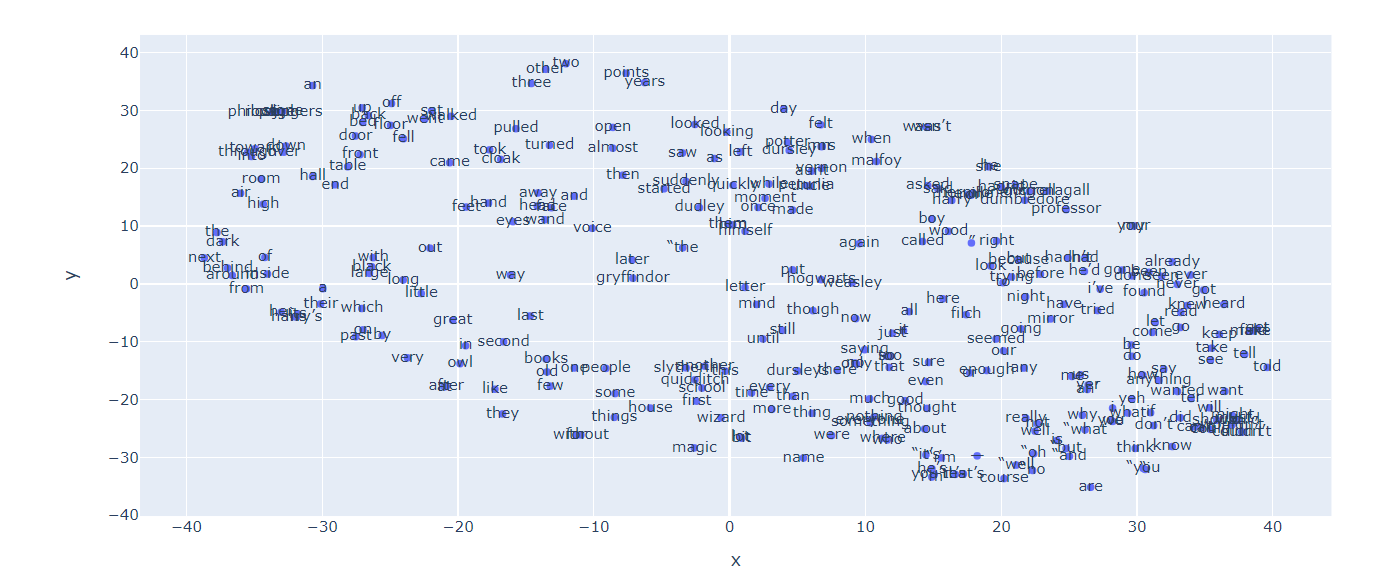

In [ ]:
# Graficar una zona para que se vea de mayor tamaño y los términos más claramente.
x_selected=[]
y_selected=[]
labels_selected=[]

for i, value_x in enumerate (x_vals[:MAX_WORDS]):
    if value_x>=16 and value_x<=25 and y_vals[i]>=10 and y_vals[i]<=20:
      x_selected.append(value_x)
      y_selected.append(y_vals[i])
      labels_selected.append(labels[i])

fig = px.scatter(x=x_selected, y=y_selected, text=labels_selected)
fig.show(renderer="colab") # Esto para plotly en Colab.

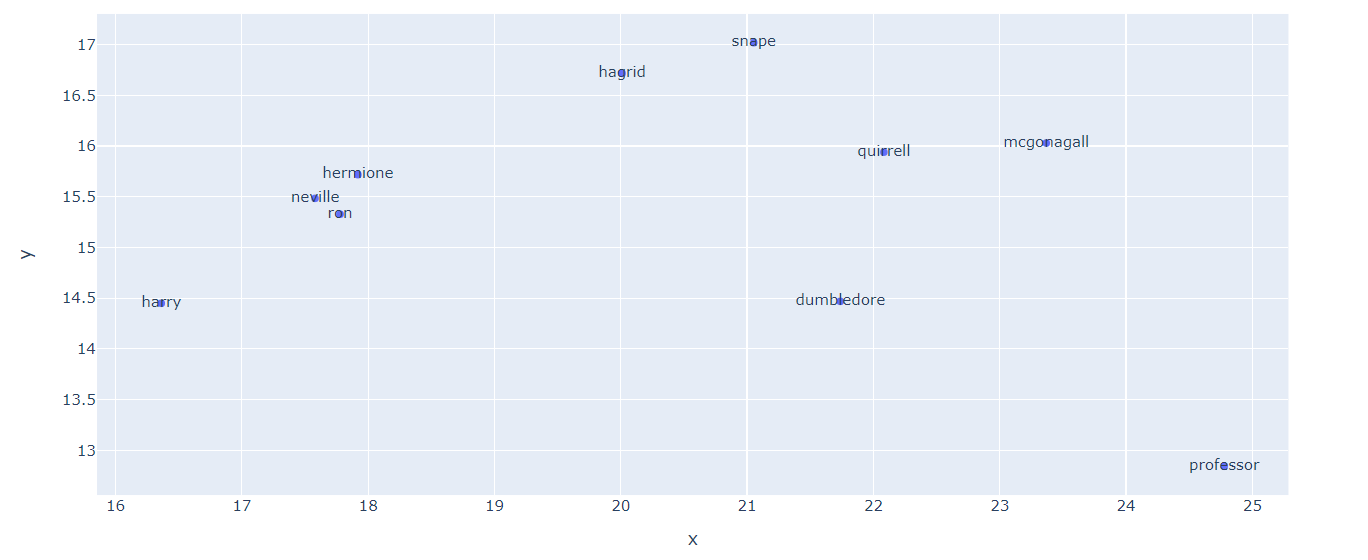

#### Conclusiones

Se puede notar claramente como en la parte derecha agrupó los nombres de los profesores protagonistas del libro, y en la parte izquierda, la de los alumnos, más precisamente Harry y sus amigos. Hagrid, que es un profesor de mucha cercanía con sus alumnos en el libro, es a su vez el profesor más cercano a ellos en el gráfico.
Por último, se observa como la palabra profesor se encuentra cerca de los nombres de los profesores.

### CBOW ventana 2

In [ ]:
# Graficar los embedddings en 2D con T-SNE.
import plotly.graph_objects as go
import plotly.express as px

x_vals, y_vals, labels = reduce_dimensions(w2v_model_CBOW)

MAX_WORDS=300
fig = px.scatter(x=x_vals[:MAX_WORDS], y=y_vals[:MAX_WORDS], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # Esto para plotly en Colab.

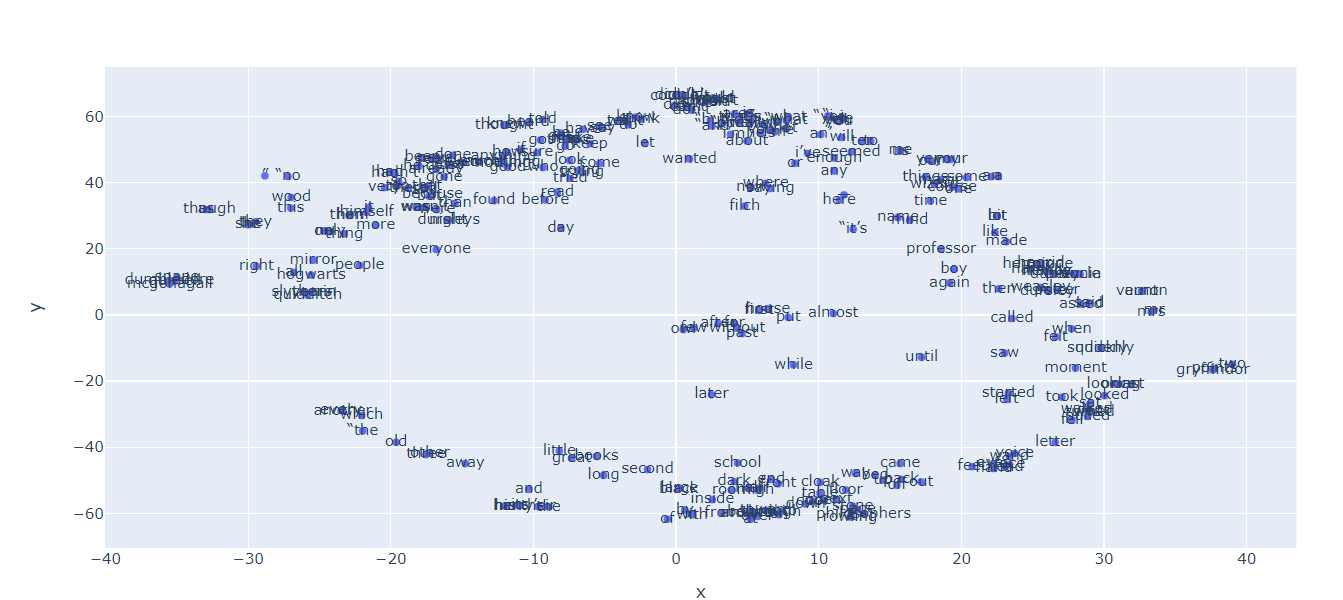

In [ ]:
# Graficar una zona para que se vea de mayor tamaño y los términos más claramente.
x_selected=[]
y_selected=[]
labels_selected=[]

for i, value_x in enumerate (x_vals[:MAX_WORDS]):
    if value_x>=-40 and value_x<=-30 and y_vals[i]<=20 and y_vals[i]>=0:
      x_selected.append(value_x)
      y_selected.append(y_vals[i])
      labels_selected.append(labels[i])

fig = px.scatter(x=x_selected, y=y_selected, text=labels_selected)
fig.show(renderer="colab") # Esto para plotly en Colab.

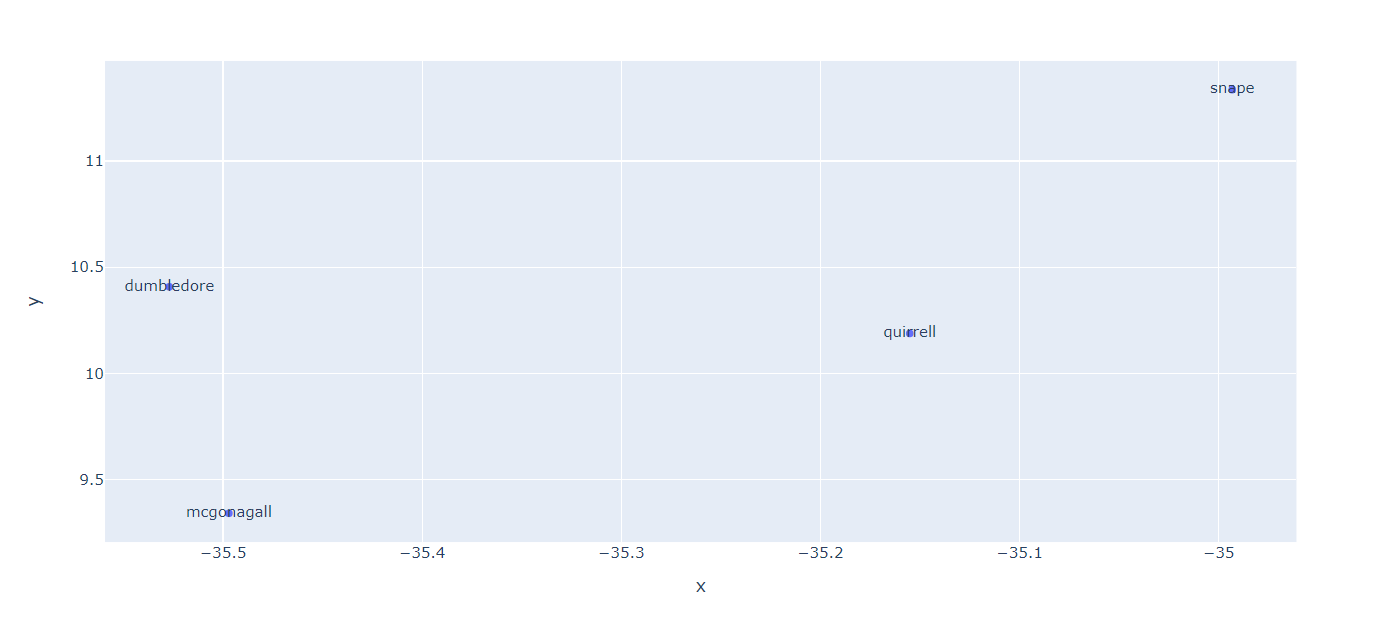

In [ ]:
# Graficar una zona para que se vea de mayor tamaño y los términos más claramente.
x_selected=[]
y_selected=[]
labels_selected=[]

for i, value_x in enumerate (x_vals[:MAX_WORDS]):
    if value_x>=20 and value_x<=26 and y_vals[i]<=20 and y_vals[i]>=10:
      x_selected.append(value_x)
      y_selected.append(y_vals[i])
      labels_selected.append(labels[i])

fig = px.scatter(x=x_selected, y=y_selected, text=labels_selected)
fig.show(renderer="colab") # Esto para plotly en Colab.

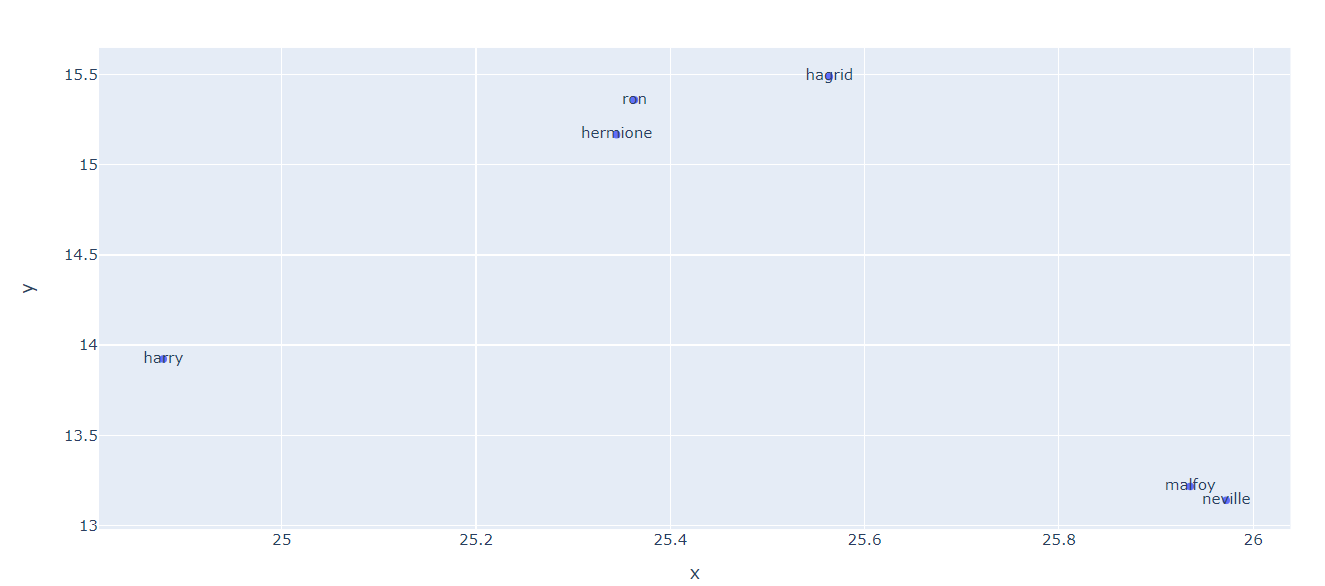

#### Conclusiones

Se puede notar claramente que existe una zona en donde se agrupan los nombres de los profesores protagonistas del libro, y otra, en donde agrupa los nombres de los alumnos, y si bien figuran Harry y sus amigos, también en este caso aparece Malfoy, que es otro alumno, y el enemigo número uno de Harry en la escuela. Notar que también en este caso aparece Hagrid junto con los alumnos, porque es un profesor que en general, tiene más participación con los alumnos que con sus propios colegas.

### CBOW ventana 4

In [ ]:
# Graficar los embedddings en 2D con T-SNE.
import plotly.graph_objects as go
import plotly.express as px

x_vals, y_vals, labels = reduce_dimensions(w2v_model_CBOW_4)

MAX_WORDS=300
fig = px.scatter(x=x_vals[:MAX_WORDS], y=y_vals[:MAX_WORDS], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # Esto para plotly en Colab.

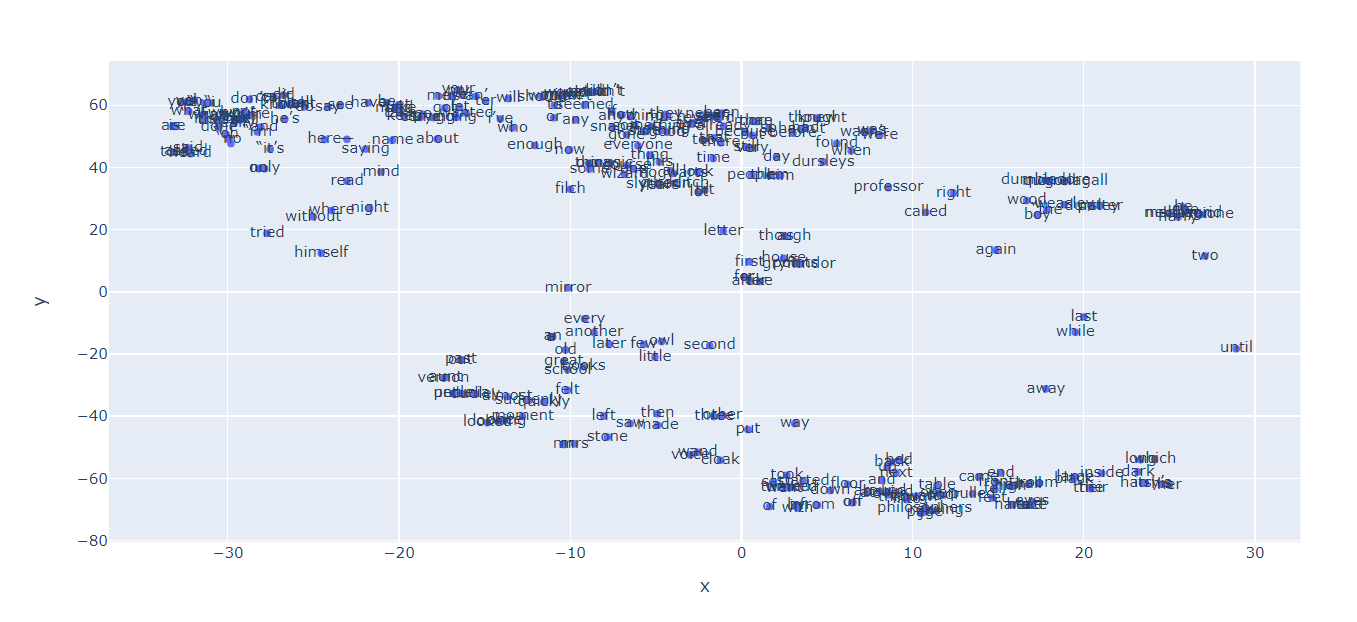

In [ ]:
# Graficar una zona para que se vea de mayor tamaño y los términos más claramente.
x_selected=[]
y_selected=[]
labels_selected=[]

for i, value_x in enumerate (x_vals[:MAX_WORDS]):
    if value_x>=15 and value_x<=30 and y_vals[i]<=40 and y_vals[i]>=20:
      x_selected.append(value_x)
      y_selected.append(y_vals[i])
      labels_selected.append(labels[i])

fig = px.scatter(x=x_selected, y=y_selected, text=labels_selected)
fig.show(renderer="colab") # Esto para plotly en Colab.

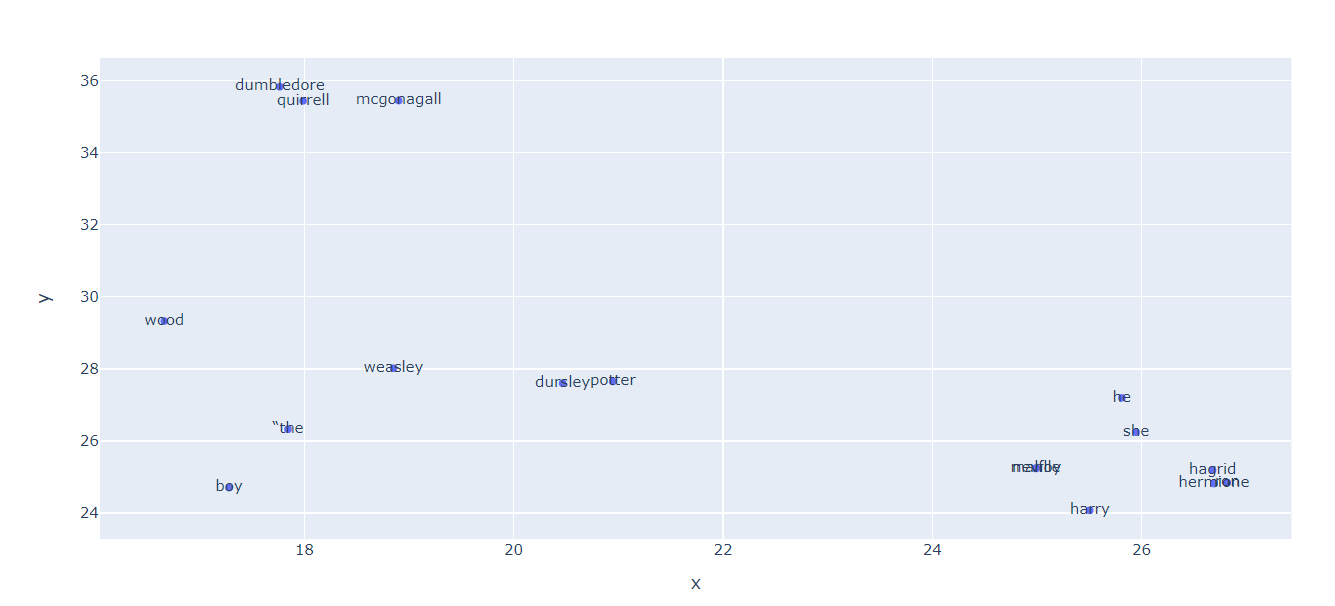

#### Conclusiones

Se puede notar claramente que existe una zona en donde se agrupan los nombres de los profesores protagonistas del libro (arriba a la izquierda), y otra, en donde agrupa los nombres de los alumnos (abajo a la derecha), y si bien figuran Harry y sus amigos, también en este caso aparece Malfoy, que es otro alumno, y el enemigo número uno de Harry en la escuela. Notar que también en este caso aparece Hagrid junto con los alumnos, porque es un profesor que en general, tiene más participación con los alumnos que con sus propios colegas.
En este caso, comparado con los anteriores, desaparece el profesor Snape.

### Comparación de los 3 casos y conclusiones

Es muy interesante como agrupa profesores por un lado, y alumnos por el otro, en todos los casos.

No obstante, algunas diferencias que es importante destacar:

* En Skip-Gram el grupo de profesores tiene cierta cercanía con el grupo de alumnos, sin embargo, en CBOW están muy separados cuando la ventana es 2, es decir, los ve como términos totalmente diferentes, y los acerca cuando se amplia la ventana a 4, aunque no se llegua a la cercanía que logra Skip-Gram.
* Hagrid es el profesor que tiene más relación con los alumnos, incluso más que con otros profesores. Por eso con Skip-Gram aparece en el grupo de los profesores, siendo el más cercano a los alumnos, mientras que con CBOW, con ambas ventanas, aparece directamente en el grupo de alumnos.
* Aparece Malfoy, enemigo número 1 en la escuela de Harry, en el grupo de alumnos para ambos casos de CBOW, en cambio no así para Skip-Gram.
* Snape aparece en Skip-Gram y en CBOW de ventana 2 en el grupo de profesores, no así en CBOW de ventana 4. Esto se relaciona también con lo analizado en la sección ensayos, en donde si se ampliaba la ventana Snape se empezaba a relacionar con términos incorrectos.